In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pl.read_csv('merged_output.csv')
print(df.head())

shape: (5, 4)
┌─────────────────────────────────┬──────────┬────────────────┬───────┐
│ content                         ┆ outlet   ┆ original_index ┆ label │
│ ---                             ┆ ---      ┆ ---            ┆ ---   │
│ str                             ┆ str      ┆ i64            ┆ i64   │
╞═════════════════════════════════╪══════════╪════════════════╪═══════╡
│ FBI arrests so-called sedition… ┆ BBC News ┆ 800            ┆ 2     │
│ House Speaker defends giving C… ┆ BBC News ┆ 801            ┆ 0     │
│ Capitol rioter who jabbed Conf… ┆ BBC News ┆ 802            ┆ 0     │
│ Capitol rioter who posed with … ┆ BBC News ┆ 803            ┆ 0     │
│ Proud Boy leader spoke of 'war… ┆ BBC News ┆ 804            ┆ 1     │
└─────────────────────────────────┴──────────┴────────────────┴───────┘


Label proportions across the datasets:
shape: (4, 3)
┌───────┬───────┬────────────┐
│ label ┆ count ┆ proportion │
│ ---   ┆ ---   ┆ ---        │
│ i64   ┆ u32   ┆ f64        │
╞═══════╪═══════╪════════════╡
│ 0     ┆ 2285  ┆ 0.339172   │
│ 1     ┆ 1454  ┆ 0.215823   │
│ 2     ┆ 2203  ┆ 0.327      │
│ 3     ┆ 795   ┆ 0.118005   │
└───────┴───────┴────────────┘
Label Counts by Outlet:
 shape: (6, 5)
┌──────────────┬─────┬──────┬─────┬─────┐
│ outlet       ┆ 2   ┆ 0    ┆ 3   ┆ 1   │
│ ---          ┆ --- ┆ ---  ┆ --- ┆ --- │
│ str          ┆ u32 ┆ u32  ┆ u32 ┆ u32 │
╞══════════════╪═════╪══════╪═════╪═════╡
│ The Guardian ┆ 991 ┆ 498  ┆ 108 ┆ 403 │
│ Jacobin      ┆ 92  ┆ 58   ┆ 232 ┆ 267 │
│ Breitbart    ┆ 190 ┆ 235  ┆ 23  ┆ 150 │
│ AP News      ┆ 234 ┆ 195  ┆ 75  ┆ 121 │
│ Fox News     ┆ 200 ┆ 1060 ┆ 108 ┆ 443 │
│ BBC News     ┆ 496 ┆ 239  ┆ 249 ┆ 70  │
└──────────────┴─────┴──────┴─────┴─────┘


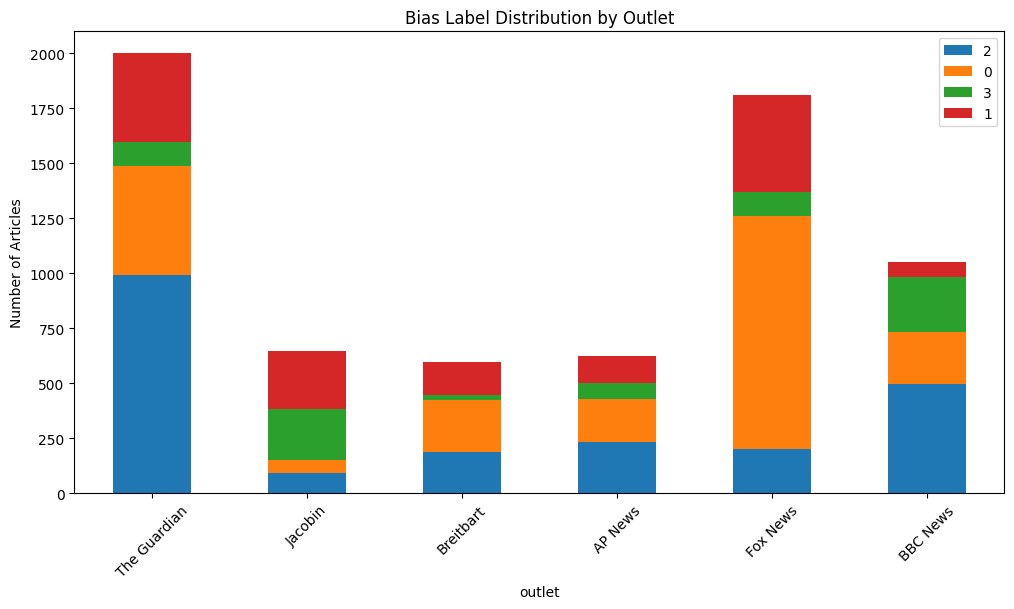

In [3]:
label_count = df.group_by('label').agg(pl.count('content').alias('count'))
label_propotition = label_count.with_columns(
    (pl.col('count') / pl.col('count').sum()).alias('proportion')
).sort('label')
print(f"Label proportions across the datasets:\n{label_propotition}")

outlet_label_counts = df.group_by(["outlet", "label"]).agg(
    pl.count("content").alias("count")
).pivot(
    index="outlet", on="label", values="count", aggregate_function="sum"
).fill_null(0)
print("Label Counts by Outlet:\n", outlet_label_counts)

outlet_label_df = outlet_label_counts.to_pandas()
outlet_label_df.set_index("outlet").plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Bias Label Distribution by Outlet")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()

Average Word Length by Label:
 shape: (4, 3)
┌───────┬─────────────────┬────────────────────┐
│ label ┆ avg_word_length ┆ median_word_length │
│ ---   ┆ ---             ┆ ---                │
│ i64   ┆ f64             ┆ f64                │
╞═══════╪═════════════════╪════════════════════╡
│ 0     ┆ 933.263457      ┆ 692.0              │
│ 1     ┆ 1397.927098     ┆ 916.5              │
│ 2     ┆ 1237.154789     ┆ 691.0              │
│ 3     ┆ 1528.535849     ┆ 673.0              │
└───────┴─────────────────┴────────────────────┘
Average Word Length by Outlet:
 shape: (6, 2)
┌──────────────┬─────────────────┐
│ outlet       ┆ avg_word_length │
│ ---          ┆ ---             │
│ str          ┆ f64             │
╞══════════════╪═════════════════╡
│ AP News      ┆ 734.8976        │
│ BBC News     ┆ 619.090133      │
│ Breitbart    ┆ 569.16388       │
│ Fox News     ┆ 914.394809      │
│ Jacobin      ┆ 2815.627119     │
│ The Guardian ┆ 1585.114        │
└──────────────┴─────────────────┘

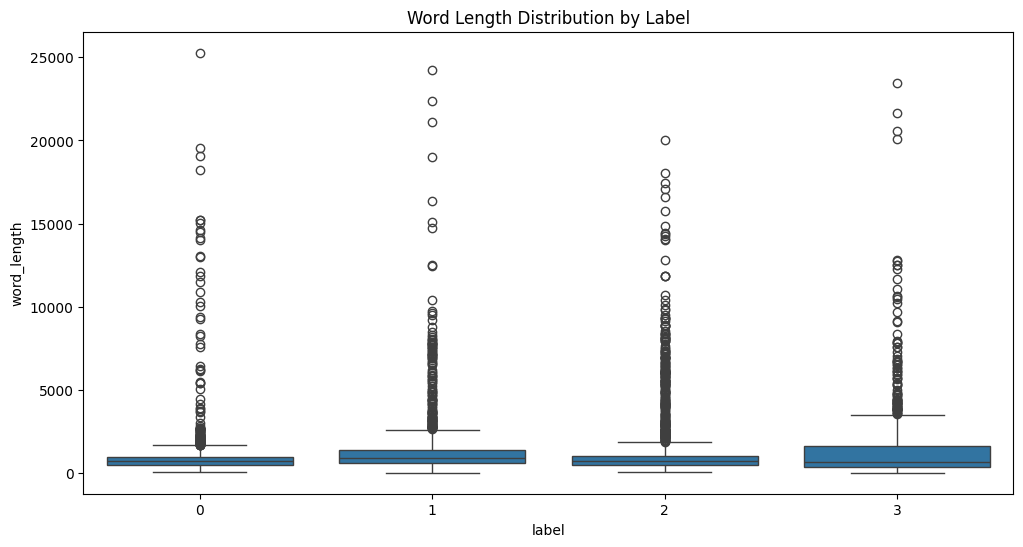

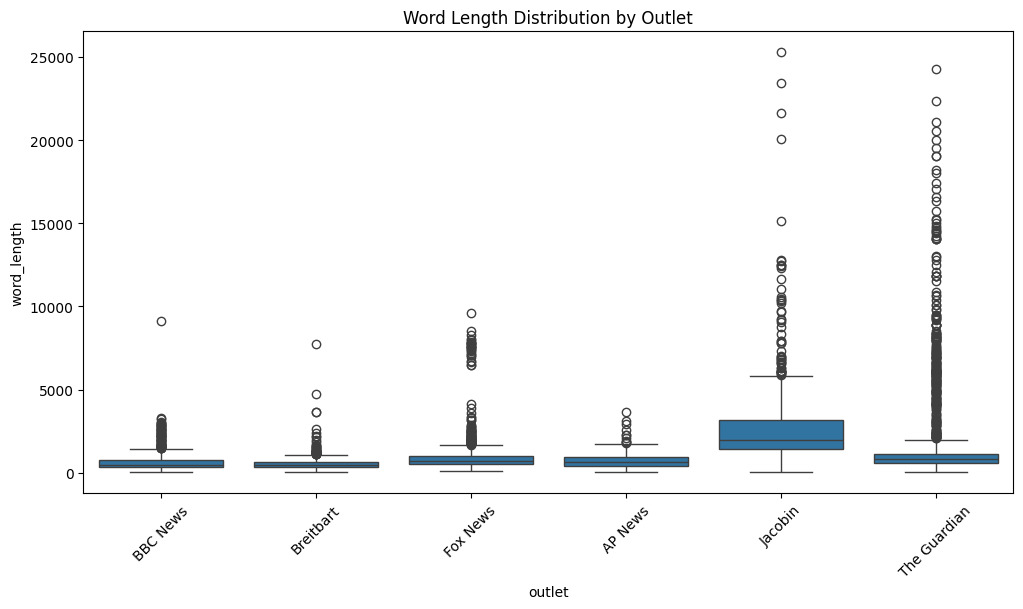

In [4]:
df = df.with_columns(pl.col("content").str.split(" ").list.len().alias("word_length"))

length_by_label = df.group_by("label").agg(
    pl.col("word_length").mean().alias("avg_word_length"),
    pl.col("word_length").median().alias("median_word_length")
).sort("label")
print("Average Word Length by Label:\n", length_by_label)

length_by_outlet = df.group_by("outlet").agg(
    pl.col("word_length").mean().alias("avg_word_length")
).sort("outlet")
print("Average Word Length by Outlet:\n", length_by_outlet)

plt.figure(figsize=(12, 6))
sns.boxplot(x="label", y="word_length", data=df.to_pandas())
plt.title("Word Length Distribution by Label")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="outlet", y="word_length", data=df.to_pandas())
plt.title("Word Length Distribution by Outlet")
plt.xticks(rotation=45)
plt.show()

In [5]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haeri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = df.with_columns(
    pl.col("content").map_elements(
        lambda x: " ".join([w for w in x.split() if w.lower() not in stop_words]),
        return_dtype=pl.Utf8  # Specify the return data type
    ).alias("clean_content")
)

words_df = df.with_columns(pl.col("clean_content").str.split(" ").alias("words")).explode("words")
word_counts = words_df.group_by(["label", "words"]).agg(pl.count("words").alias("count")).sort(["label", "count"], descending=[False, True])

# Create a dictionary to store top words for each label
top_words_by_label = {}

# Populate the dictionary with top 50 words for each label
for label in word_counts["label"].unique():
    top_words_by_label[label] = word_counts.filter(pl.col("label") == label).head(10)

# Optional: Print the results to verify
for label, words_df in top_words_by_label.items():
    print(f"Top 50 words for label {label}:")
    print(words_df)
    print("\n")

total_words_per_label = word_counts.group_by("label").agg(pl.col("count").sum().alias("total_words"))
word_props = word_counts.join(total_words_per_label, on="label").with_columns(
    (pl.col("count") / pl.col("total_words")).alias("prop")
)

for label in word_props["label"].unique():
    label_words = word_props.filter(pl.col("label") == label)
    other_max_prop = word_props.filter(pl.col("label") != label).group_by("words").agg(pl.col("prop").max().alias("max_other_prop"))
    unique_words = label_words.join(other_max_prop, on="words").filter(
        pl.col("prop") > 2 * pl.col("max_other_prop")
    ).sort("prop", descending=True).head(10)
    print(f"Unique words for label {label}:\n", unique_words)

Top 50 words for label 0:
shape: (10, 3)
┌───────┬───────────┬───────┐
│ label ┆ words     ┆ count │
│ ---   ┆ ---       ┆ ---   │
│ i64   ┆ str       ┆ u32   │
╞═══════╪═══════════╪═══════╡
│ 0     ┆ Trump     ┆ 12749 │
│ 0     ┆ said      ┆ 8070  │
│ 0     ┆ Biden     ┆ 5938  │
│ 0     ┆ would     ┆ 5657  │
│ 0     ┆ House     ┆ 4914  │
│ 0     ┆ also      ┆ 4101  │
│ 0     ┆ election  ┆ 3850  │
│ 0     ┆ President ┆ 3833  │
│ 0     ┆ former    ┆ 3595  │
│ 0     ┆ US        ┆ 3511  │
└───────┴───────────┴───────┘


Top 50 words for label 1:
shape: (10, 3)
┌───────┬────────┬───────┐
│ label ┆ words  ┆ count │
│ ---   ┆ ---    ┆ ---   │
│ i64   ┆ str    ┆ u32   │
╞═══════╪════════╪═══════╡
│ 1     ┆ Trump  ┆ 6088  │
│ 1     ┆ people ┆ 4345  │
│ 1     ┆ —      ┆ 4250  │
│ 1     ┆ would  ┆ 4241  │
│ 1     ┆ said   ┆ 4051  │
│ 1     ┆ US     ┆ 3705  │
│ 1     ┆ one    ┆ 3391  │
│ 1     ┆ Biden  ┆ 3207  │
│ 1     ┆ also   ┆ 3144  │
│ 1     ┆ like   ┆ 2640  │
└───────┴────────┴───────┘


To

In [21]:
import textstat

df = df.with_columns(
    pl.col("content").map_elements(
        lambda x: textstat.flesch_kincaid_grade(x) if x else None, return_dtype=pl.Float64  # Specify the return data type
    ).alias("fk_grade")
)

fk_by_label = df.group_by("label").agg(pl.col("fk_grade").mean().alias("avg_fk_grade")).sort("label")
print("Average FK Grade by Label:\n", fk_by_label)

fk_by_outlet = df.group_by("outlet").agg(pl.col("fk_grade").mean().alias("avg_fk_grade")).sort("outlet")
print("Average FK Grade by Outlet:\n", fk_by_outlet)

Average FK Grade by Label:
 shape: (4, 2)
┌───────┬──────────────┐
│ label ┆ avg_fk_grade │
│ ---   ┆ ---          │
│ i64   ┆ f64          │
╞═══════╪══════════════╡
│ 0     ┆ 12.490678    │
│ 1     ┆ 12.238652    │
│ 2     ┆ 12.88788     │
│ 3     ┆ 12.637987    │
└───────┴──────────────┘
Average FK Grade by Outlet:
 shape: (6, 2)
┌──────────────┬──────────────┐
│ outlet       ┆ avg_fk_grade │
│ ---          ┆ ---          │
│ str          ┆ f64          │
╞══════════════╪══════════════╡
│ AP News      ┆ 12.37392     │
│ BBC News     ┆ 11.901898    │
│ Breitbart    ┆ 12.499833    │
│ Fox News     ┆ 12.084815    │
│ Jacobin      ┆ 13.476579    │
│ The Guardian ┆ 13.19515     │
└──────────────┴──────────────┘


In [22]:
word_counts_outlet = words_df.group_by(["outlet", "words"]).agg(pl.count("words").alias("count"))
for outlet in word_counts_outlet["outlet"].unique():
    outlet_words = word_counts_outlet.filter(pl.col("outlet") == outlet)
    other_max_count = word_counts_outlet.filter(pl.col("outlet") != outlet).group_by("words").agg(pl.col("count").max().alias("max_other_count"))
    unique_words = outlet_words.join(other_max_count, on="words").filter(
        pl.col("count") > 2 * pl.col("max_other_count")
    ).sort("count", descending=True).head(10)
    print(f"Unique words for {outlet}:\n", unique_words)

Unique words for The Guardian:
 shape: (10, 4)
┌──────────────┬──────────┬───────┬─────────────────┐
│ outlet       ┆ words    ┆ count ┆ max_other_count │
│ ---          ┆ ---      ┆ ---   ┆ ---             │
│ str          ┆ str      ┆ u32   ┆ u32             │
╞══════════════╪══════════╪═══════╪═════════════════╡
│ The Guardian ┆ said     ┆ 15609 ┆ 4861            │
│ The Guardian ┆ US       ┆ 9518  ┆ 2132            │
│ The Guardian ┆ –        ┆ 8296  ┆ 1561            │
│ The Guardian ┆ also     ┆ 5968  ┆ 2883            │
│ The Guardian ┆ Russian  ┆ 4609  ┆ 466             │
│ The Guardian ┆ could    ┆ 4042  ┆ 1986            │
│ The Guardian ┆ last     ┆ 4039  ┆ 1700            │
│ The Guardian ┆ Israeli  ┆ 3772  ┆ 593             │
│ The Guardian ┆ first    ┆ 3709  ┆ 1775            │
│ The Guardian ┆ military ┆ 3667  ┆ 630             │
└──────────────┴──────────┴───────┴─────────────────┘
Unique words for AP News:
 shape: (10, 4)
┌─────────┬───────┬───────┬─────────────────┐
│

In [23]:
df = df.with_columns(pl.col("content").str.split("\n\n").list.len().alias("paragraph_count"))
para_by_label = df.group_by("label").agg(pl.col("paragraph_count").mean().alias("avg_paragraph_count")).sort("label")
print("Average Paragraph Count by Label:\n", para_by_label)

Average Paragraph Count by Label:
 shape: (4, 2)
┌───────┬─────────────────────┐
│ label ┆ avg_paragraph_count │
│ ---   ┆ ---                 │
│ i64   ┆ f64                 │
╞═══════╪═════════════════════╡
│ 0     ┆ 1.000875            │
│ 1     ┆ 1.002063            │
│ 2     ┆ 1.001816            │
│ 3     ┆ 1.001258            │
└───────┴─────────────────────┘


In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
df = df.with_columns(
    pl.col("content").map_elements(lambda x: analyzer.polarity_scores(x)["compound"], return_dtype=pl.Float64).alias("sentiment")
)

sentiment_by_label = df.group_by("label").agg(pl.col("sentiment").mean().alias("avg_sentiment")).sort("label")
print("Average Sentiment by Label:\n", sentiment_by_label)

Average Sentiment by Label:
 shape: (4, 2)
┌───────┬───────────────┐
│ label ┆ avg_sentiment │
│ ---   ┆ ---           │
│ i64   ┆ f64           │
╞═══════╪═══════════════╡
│ 0     ┆ 0.003952      │
│ 1     ┆ -0.020886     │
│ 2     ┆ -0.192685     │
│ 3     ┆ 0.185994      │
└───────┴───────────────┘


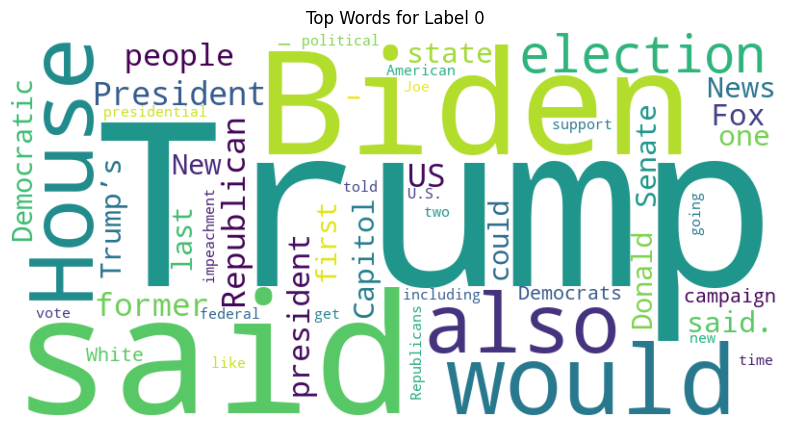

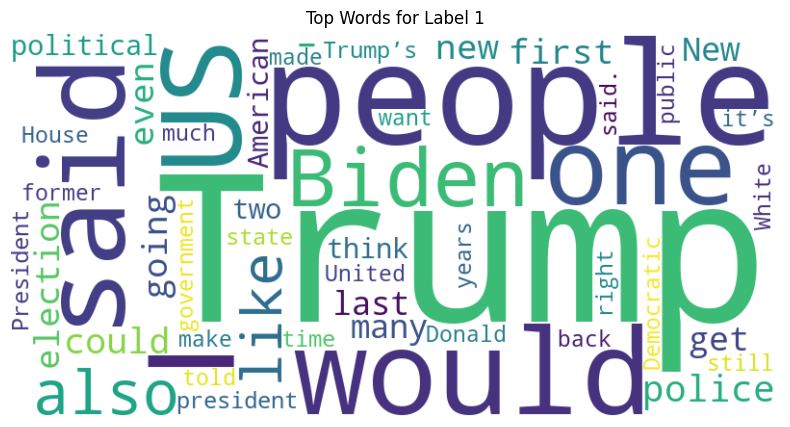

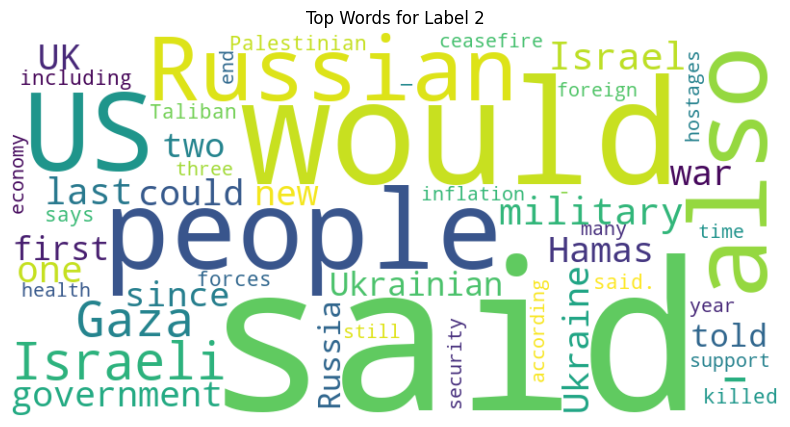

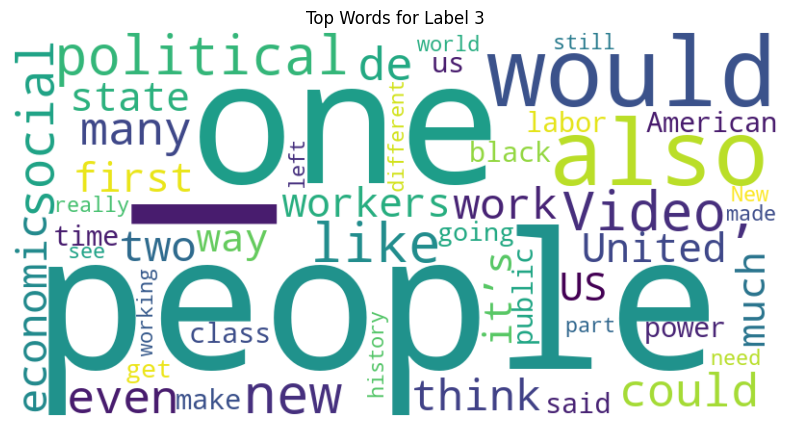

In [34]:
from wordcloud import WordCloud  # Import the class, not the module

word_data = top_words_by_label

for label, words_df in word_data.items():
    # Convert DataFrame to dictionary of word frequencies
    word_freq_dict = dict(zip(words_df["words"].to_list(), words_df["count"].to_list()))
    
    # Create the wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict)
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Top Words for Label {label}")
    plt.show()

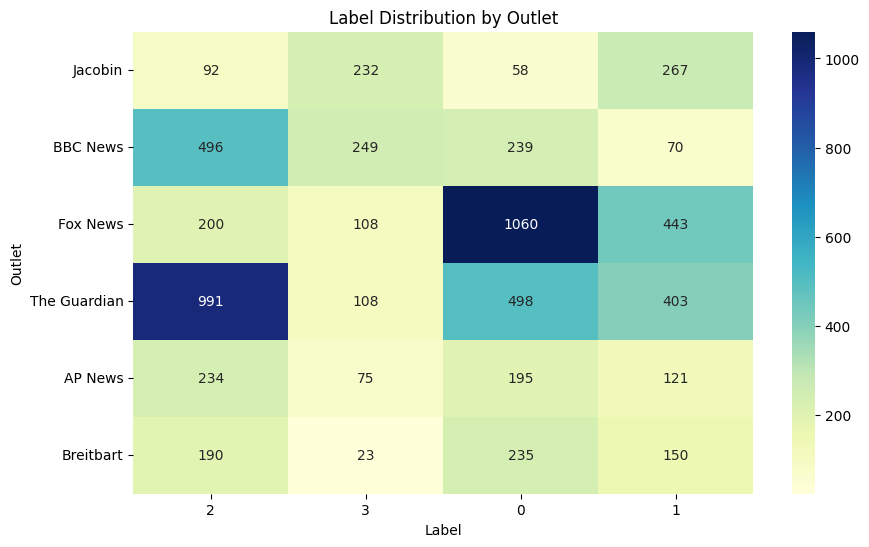

In [36]:
# Your data is already a Polars DataFrame
data = outlet_label_counts

# Convert the Polars DataFrame to pandas DataFrame first
pandas_df = data.to_pandas()

# Now set the index using pandas method
pandas_df = pandas_df.set_index("outlet")

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pandas_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Label Distribution by Outlet")
plt.xlabel("Label")
plt.ylabel("Outlet")
plt.show()  # Display the heatmap

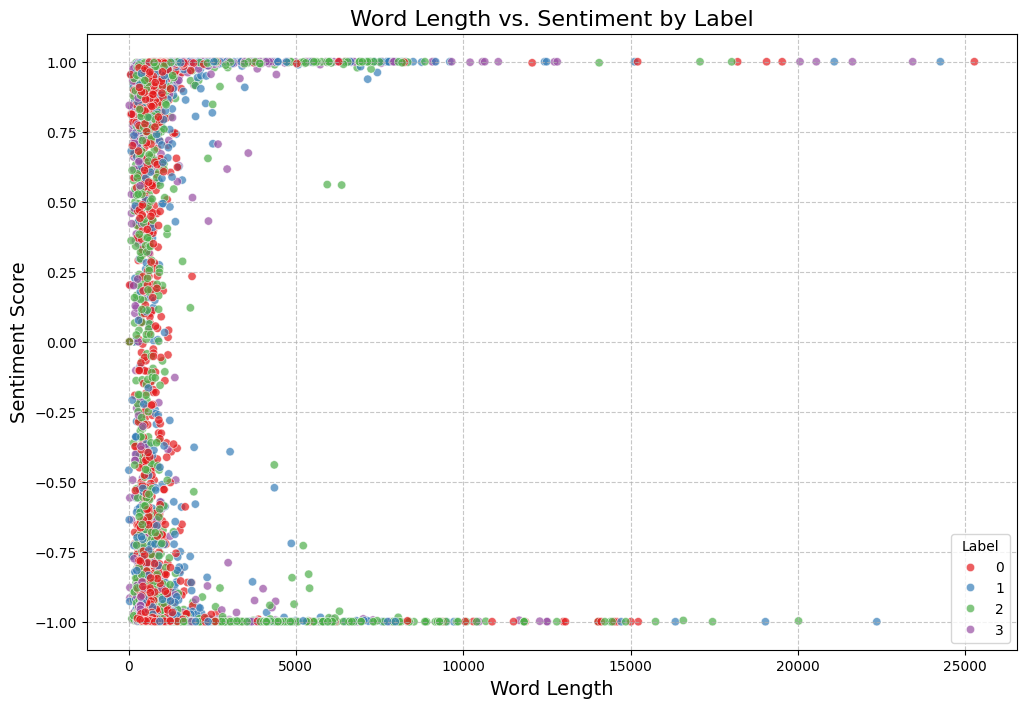

In [37]:
# Create scatter plot using the existing DataFrame
# This assumes df already has label, word_length, and sentiment columns
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df.to_pandas(),  # Use your actual data, no need to create new data
    x="word_length", 
    y="sentiment", 
    hue="label", 
    palette="Set1",
    alpha=0.7
)

plt.title("Word Length vs. Sentiment by Label", fontsize=16)
plt.xlabel("Word Length", fontsize=14)
plt.ylabel("Sentiment Score", fontsize=14)
plt.legend(title="Label")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("scatter_wordlength_sentiment.png", dpi=300)
plt.show()

Preprocess data

In [67]:
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haeri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\haeri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haeri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haeri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Keeps letters, numbers, and spaces
    return text

def lowercase(text):
    return text.lower()

def preprocess_text(text):
    text = remove_html(text)
    text = clean_text(text)
    text = lowercase(text)
    return text

In [48]:
df = df.with_columns(
    pl.col("content").map_elements(preprocess_text, return_dtype=pl.Utf8).alias("clean_content")
)
print(df['clean_content'].head())

shape: (10,)
Series: 'clean_content' [str]
[
	"fbi arrests socalled sedition …
	"house speaker defends giving c…
	"capitol rioter who jabbed conf…
	"capitol rioter who posed with …
	"proud boy leader spoke of war …
	"proud boys face conspiracy tri…
	"farright influencer baked alas…
	"farright groups had racism rif…
	"capitol riot committee seeks f…
	"capitol riot panel recommends …
]


Tokenization

In [56]:
def tokenize(text):
    return word_tokenize(text)

In [58]:
df = df.with_columns(
    pl.col('clean_content').map_elements(tokenize, return_dtype=pl.List(pl.Utf8)).alias('tokens')
)
print(df['tokens'].head())

shape: (10,)
Series: 'tokens' [list[str]]
[
	["fbi", "arrests", … "capitol"]
	["house", "speaker", … "comment"]
	["capitol", "rioter", … "far"]
	["capitol", "rioter", … "prison"]
	["proud", "boy", … "years"]
	["proud", "boys", … "weeks"]
	["farright", "influencer", … "beliefs"]
	["farright", "groups", … "says"]
	["capitol", "riot", … "riot"]
	["capitol", "riot", … "riot"]
]


Stop Word Removal

In [60]:
stop_words = set(stopwords.words('english')) - {'left', 'right'}  # Customize
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

In [61]:
df = df.with_columns(
    pl.col('tokens').map_elements(remove_stopwords, return_dtype=pl.List(pl.Utf8)).alias('tokens_no_stop')
)
print(df['tokens_no_stop'].head())

shape: (10,)
Series: 'tokens_no_stop' [list[str]]
[
	["fbi", "arrests", … "capitol"]
	["house", "speaker", … "comment"]
	["capitol", "rioter", … "far"]
	["capitol", "rioter", … "prison"]
	["proud", "boy", … "years"]
	["proud", "boys", … "weeks"]
	["farright", "influencer", … "beliefs"]
	["farright", "groups", … "says"]
	["capitol", "riot", … "riot"]
	["capitol", "riot", … "riot"]
]


Lemmatization

In [64]:
lemmatizer = WordNetLemmatizer()
def lemmatize(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

In [65]:
df = df.with_columns(
    pl.col('tokens_no_stop').map_elements(lemmatize, return_dtype=pl.List(pl.Utf8)).alias('tokens_lemmatized')
)
print(df['tokens_lemmatized'].head())

shape: (10,)
Series: 'tokens_lemmatized' [list[str]]
[
	["fbi", "arrest", … "capitol"]
	["house", "speaker", … "comment"]
	["capitol", "rioter", … "far"]
	["capitol", "rioter", … "prison"]
	["proud", "boy", … "year"]
	["proud", "boy", … "week"]
	["farright", "influencer", … "belief"]
	["farright", "group", … "say"]
	["capitol", "riot", … "riot"]
	["capitol", "riot", … "riot"]
]


Handling Rare Words

In [69]:
vectorizer = CountVectorizer(min_df=5)  # Words must appear in 5+ articles
X = vectorizer.fit_transform(df['clean_content'])  
vocab = vectorizer.get_feature_names_out()
# Re-filter tokens based on vocab
def filter_rare(tokens):
    return [word for word in tokens if word in vocab]

In [70]:
df = df.with_columns(
    pl.col('tokens_lemmatized').map_elements(filter_rare, return_dtype=pl.List(pl.Utf8)).alias('tokens_filtered')
)
print(df['tokens_filtered'].head())

ComputeError: KeyboardInterrupt: 

In [ ]:
print(len(vocab))